## Dataset: Maternal Health Risk

### Licence of use

- That dataset was collected from UCI Machine Learning Repository -https://archive.ics.uci.edu/dataset/863/maternal+health+risk

- licence by Creative Commons Attribution 4.0 (CC BY 4.0) https://creativecommons.org/licenses/by/4.0/


## About the dataset

- The Data has been collected from different hospitals, community clinics, maternal health cares from the rural areas of Bangladesh through the IoT based risk monitoring system.

###  Attributes Description:

- Age - Age in years when a woman is pregnant
- SystolicBP - Upper value of Blood Pressure in mmHg
- DiastolicBP - Lower value of Blood Pressure in mmHg
- BS - Blood glucose levels is in terms of a molar concentration, mmol/L
- BodyTemp - Body temperature in Fahrenheit
- HeartRate - Resting heart rate in beats per minute
- RiskLevel - Predicted Risk Intensity Level during pregnancy ['high risk', 'mid risk', 'low risk']

In [1]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [2]:
# Load the libraries
import os
import numpy as np
import pandas as pd
from pyspark.sql.types import *
from pyspark.ml import Pipeline
from pyspark.sql import functions as f
from pyspark.sql.functions import udf, StringType
from pyspark.sql import SparkSession, functions as F
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, StringIndexer

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Due the different version of python can be found and each machine or libriries 
# Avoid warnigs
import warnings
warnings.filterwarnings("ignore")

# 2. Data Understanding Phase

### Practical Big Data (PySparkSQL) - Part 1

In [4]:
#Import PySparkSQL
import pyspark
from pyspark.sql import SparkSession        

# Create SparkSession
spark = (SparkSession
  .builder
  .appName("SparkSQL")
  .getOrCreate())

# Path to dataset
csv_file = "/user/user1/Maternal_Health_Risk.csv"

In [5]:
# Read and create a temporary view
df = (spark.read.format("csv")
  .option("inferSchema", "true")
  .option("header", "true")
  .load(csv_file))
df.createOrReplaceTempView("rawdata")

In [6]:
# Visualise inferred schema
data = spark.sql("SELECT * FROM rawdata")
data.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- SystolicBP: integer (nullable = true)
 |-- DiastolicBP: integer (nullable = true)
 |-- BS: double (nullable = true)
 |-- BodyTemp: double (nullable = true)
 |-- HeartRate: integer (nullable = true)
 |-- RiskLevel: string (nullable = true)



In [7]:
# Display 5 first rows
data.show(5)

+---+----------+-----------+----+--------+---------+---------+
|Age|SystolicBP|DiastolicBP|  BS|BodyTemp|HeartRate|RiskLevel|
+---+----------+-----------+----+--------+---------+---------+
| 25|       130|         80|15.0|    98.0|       86|high risk|
| 35|       140|         90|13.0|    98.0|       70|high risk|
| 29|        90|         70| 8.0|   100.0|       80|high risk|
| 30|       140|         85| 7.0|    98.0|       70|high risk|
| 35|       120|         60| 6.1|    98.0|       76| low risk|
+---+----------+-----------+----+--------+---------+---------+
only showing top 5 rows



In [8]:
# Register the DataFrame as a temporary view
data.createOrReplaceTempView("RiskLevel")

# Get the count of rows using SQL
spark.sql("SELECT COUNT(1) FROM RiskLevel").show()

+--------+
|count(1)|
+--------+
|    1014|
+--------+



In [9]:
# Counting the occurrences of each value in the "RiskLevel" column
result = spark.sql("SELECT RiskLevel, COUNT(*) AS count FROM RiskLevel GROUP BY RiskLevel")

# Displaying the result
result.show()

+---------+-----+
|RiskLevel|count|
+---------+-----+
| low risk|  406|
| mid risk|  336|
|high risk|  272|
+---------+-----+



In [10]:
from pyspark.sql.functions import max, min

# Finding the maximum and minimum age
max_age = data.select(max("Age")).collect()[0][0]
min_age = data.select(min("Age")).collect()[0][0]

# Displaying the results
print("Maximum Age:", max_age)
print("Minimum Age:", min_age)

Maximum Age: 70
Minimum Age: 10


In [11]:
from pyspark.sql.functions import max, min

# Grouping by RiskLevel and calculating maximum and minimum values for SystolicBP and DiastolicBP
risk_stats = data.groupBy("RiskLevel").agg(
    max("SystolicBP").alias("MaxSystolicBP"),
    min("SystolicBP").alias("MinSystolicBP"),
    max("DiastolicBP").alias("MaxDiastolicBP"),
    min("DiastolicBP").alias("MinDiastolicBP")
)

# Displaying the results
risk_stats.show()

+---------+-------------+-------------+--------------+--------------+
|RiskLevel|MaxSystolicBP|MinSystolicBP|MaxDiastolicBP|MinDiastolicBP|
+---------+-------------+-------------+--------------+--------------+
| low risk|          129|           70|           100|            49|
| mid risk|          140|           70|           100|            50|
|high risk|          160|           83|           100|            60|
+---------+-------------+-------------+--------------+--------------+



In [12]:
# Selecting Age, BodyTemperature, HeartRate, and RiskLevel columns
selected_columns = data.select("Age", "BodyTemp", "HeartRate", "RiskLevel")

# Displaying the selected columns
selected_columns.show()

+---+--------+---------+---------+
|Age|BodyTemp|HeartRate|RiskLevel|
+---+--------+---------+---------+
| 25|    98.0|       86|high risk|
| 35|    98.0|       70|high risk|
| 29|   100.0|       80|high risk|
| 30|    98.0|       70|high risk|
| 35|    98.0|       76| low risk|
| 23|    98.0|       70|high risk|
| 23|    98.0|       78| mid risk|
| 35|   102.0|       86|high risk|
| 32|    98.0|       70| mid risk|
| 42|    98.0|       70|high risk|
| 23|    98.0|       76| low risk|
| 19|    98.0|       70| mid risk|
| 25|    98.0|       77| low risk|
| 20|   100.0|       70| mid risk|
| 48|    98.0|       88| mid risk|
| 15|    98.0|       70| low risk|
| 50|    98.0|       90|high risk|
| 25|    98.0|       80|high risk|
| 30|   101.0|       76| mid risk|
| 10|    98.0|       70| low risk|
+---+--------+---------+---------+
only showing top 20 rows



# 3. Data Preparation Phase

### Missing values

In [13]:
import pyspark.sql.functions as fn

# Compute the percentage of missing values for each column
missingDF = df.agg(*[
    (1 - (fn.count(c) / fn.count('*'))).alias(c + '_miss')
    for c in df.columns
]).toPandas()

# Display the DataFrame
print(missingDF)

   Age_miss  SystolicBP_miss  DiastolicBP_miss  BS_miss  BodyTemp_miss  \
0       0.0              0.0               0.0      0.0            0.0   

   HeartRate_miss  RiskLevel_miss  
0             0.0             0.0  


- No missing values 

In [14]:
# Import necessary libraries
from pyspark.sql import SparkSession

# Start Spark session
spark = SparkSession.builder \
    .appName("Spark to Pandas") \
    .getOrCreate()

# Load PySpark DataFrame from CSV
spark_df = spark.read.csv("/user/user1/Maternal_Health_Risk.csv", header=True, inferSchema=True)

# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = spark_df.toPandas()

# Display first few rows of Pandas DataFrame
print(pandas_df.head())

   Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel
0   25         130           80  15.0      98.0         86  high risk
1   35         140           90  13.0      98.0         70  high risk
2   29          90           70   8.0     100.0         80  high risk
3   30         140           85   7.0      98.0         70  high risk
4   35         120           60   6.1      98.0         76   low risk


In [15]:
# Display statistical description of the Pandas DataFrame
print(pandas_df.describe())

               Age   SystolicBP  DiastolicBP           BS     BodyTemp  \
count  1014.000000  1014.000000  1014.000000  1014.000000  1014.000000   
mean     29.871795   113.198225    76.460552     8.725986    98.665089   
std      13.474386    18.403913    13.885796     3.293532     1.371384   
min      10.000000    70.000000    49.000000     6.000000    98.000000   
25%      19.000000   100.000000    65.000000     6.900000    98.000000   
50%      26.000000   120.000000    80.000000     7.500000    98.000000   
75%      39.000000   120.000000    90.000000     8.000000    98.000000   
max      70.000000   160.000000   100.000000    19.000000   103.000000   

         HeartRate  
count  1014.000000  
mean     74.301775  
std       8.088702  
min       7.000000  
25%      70.000000  
50%      76.000000  
75%      80.000000  
max      90.000000  


In [31]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the LabelEncoder to the unique values in the 'RiskLevel' column and transform the column
pandas_df['RiskLevel_encoded'] = label_encoder.fit_transform(pandas_df['RiskLevel'])

# Remove the 'risk_level_encoded' column if it exists
if 'risk_level_encoded' in pandas_df.columns:
    pandas_df.drop(columns=['risk_level_encoded'], inplace=True)

# Display the original and encoded mappings
print("Original RiskLevel values:")
print(pandas_df['RiskLevel'].unique())
print("\nEncoded RiskLevel values:")
print(pandas_df['RiskLevel_encoded'].unique())

# Display the first few rows of the DataFrame with the encoded column
print(pandas_df.head())

Original RiskLevel values:
['high risk' 'low risk' 'mid risk']

Encoded RiskLevel values:
[0 1 2]
   Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel  \
0   25         130           80  15.0      98.0         86  high risk   
1   35         140           90  13.0      98.0         70  high risk   
2   29          90           70   8.0     100.0         80  high risk   
3   30         140           85   7.0      98.0         70  high risk   
4   35         120           60   6.1      98.0         76   low risk   

   RiskLevel_encoded  
0                  0  
1                  0  
2                  0  
3                  0  
4                  1  


- Exporting the DataFrame to a CSV file facilitates data preparation for neural networks. CSV files provide a structured format widely used for tabular data, ensuring compatibility with neural network frameworks like TensorFlow or PyTorch. This step streamlines data preprocessing, making it easier to load and manipulate data during neural network training.

In [45]:
# Export the pandas DataFrame to a CSV file
pandas_df.to_csv('Maternal_Health_Risk_encoded.csv', index=False)

## Correlation

In [46]:
import pandas as pd

# Load the encoded DataFrame from the CSV file
encoded_df = pd.read_csv('Maternal_Health_Risk_encoded.csv')

# Compute the correlation matrix
correlation_matrix = encoded_df.corr()

# Print the correlation matrix
print(correlation_matrix)

                        Age  SystolicBP  DiastolicBP        BS  BodyTemp  \
Age                1.000000    0.416045     0.398026  0.473284 -0.255323   
SystolicBP         0.416045    1.000000     0.787006  0.425172 -0.286616   
DiastolicBP        0.398026    0.787006     1.000000  0.423824 -0.257538   
BS                 0.473284    0.425172     0.423824  1.000000 -0.103493   
BodyTemp          -0.255323   -0.286616    -0.257538 -0.103493  1.000000   
HeartRate          0.079798   -0.023108    -0.046151  0.142867  0.098771   
RiskLevel_encoded -0.211851   -0.208797    -0.284633 -0.479958 -0.006680   

                   HeartRate  RiskLevel_encoded  
Age                 0.079798          -0.211851  
SystolicBP         -0.023108          -0.208797  
DiastolicBP        -0.046151          -0.284633  
BS                  0.142867          -0.479958  
BodyTemp            0.098771          -0.006680  
HeartRate           1.000000          -0.111637  
RiskLevel_encoded  -0.111637           1.

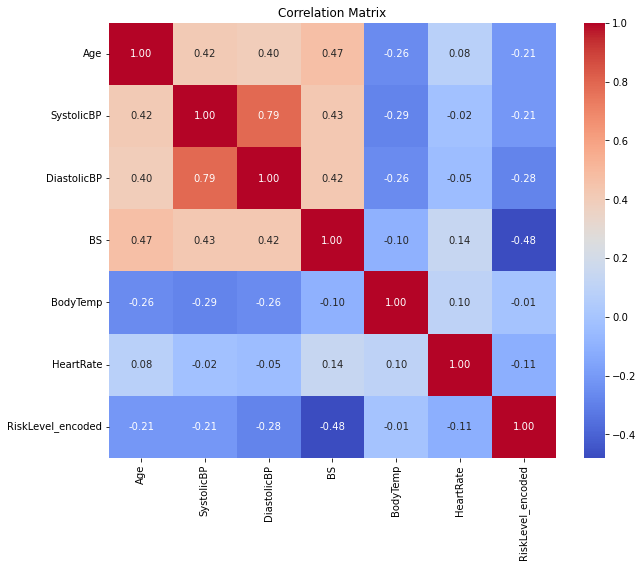

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Define the numerical columns
numerical_columns = ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate', 'RiskLevel_encoded']

# Load the encoded DataFrame from the CSV file
encoded_df = pd.read_csv('Maternal_Health_Risk_encoded.csv')

# Compute the correlation matrix
correlation_matrix = encoded_df[numerical_columns].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

#### Age vs. Other Variables:
- Weak positive correlation with SystolicBP and DiastolicBP.
- Moderate positive correlation with BS.
- Weak negative correlation with BodyTemp.
- Very weak correlation with HeartRate.
- Weak negative correlation with RiskLevel_encoded.

#### SystolicBP vs. Other Variables:
- Strong positive correlation with DiastolicBP.
- Weak positive correlation with BS.
- Weak negative correlation with BodyTemp.
- Very weak correlation with HeartRate.
- Weak negative correlation with RiskLevel_encoded.

#### DiastolicBP vs. Other Variables:
- Highly correlated with SystolicBP.
- Weak negative correlation with RiskLevel_encoded.

#### BS vs. Other Variables:
- Weak positive correlation with HeartRate.
- Strong negative correlation with RiskLevel_encoded.

#### BodyTemp vs. Other Variables:
- Very weak correlation with HeartRate.
- Very weak correlation with RiskLevel_encoded.

#### HeartRate vs. Other Variables:
- Very weak correlation with BS.
- Very weak negative correlation with RiskLevel_encoded.

#### RiskLevel_encoded vs. Other Variables:
- Weak negative correlation with Age, SystolicBP, DiastolicBP, and BodyTemp.
- Strong negative correlation with BS.
- Very weak negative correlation with HeartRate.

### Histogram

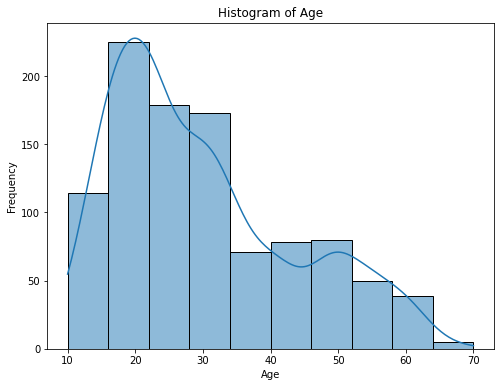

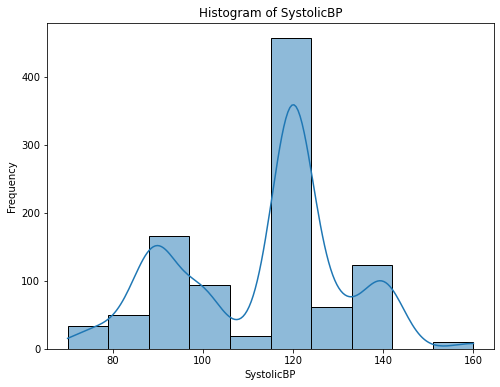

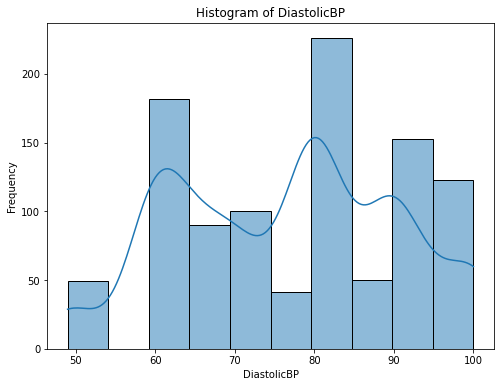

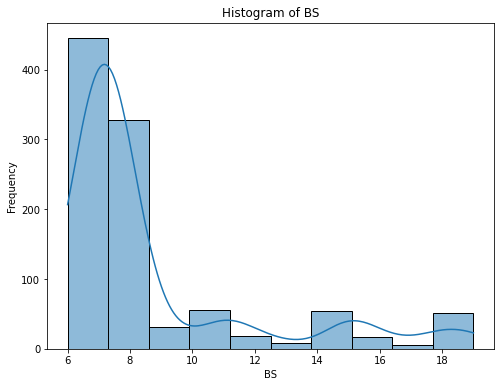

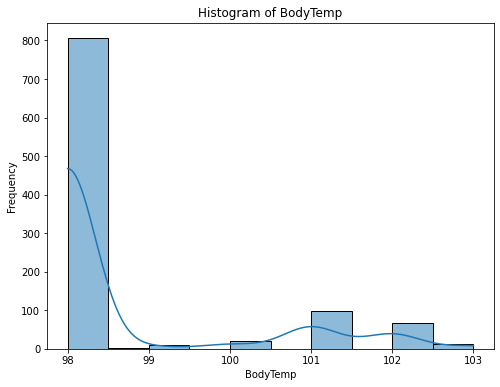

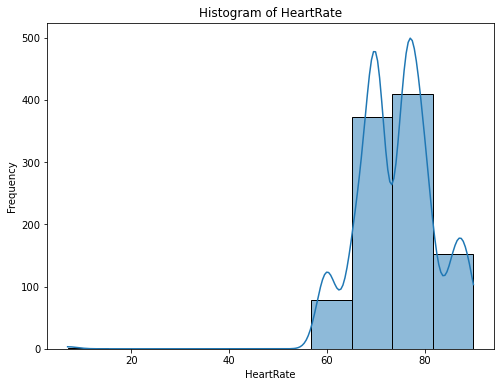

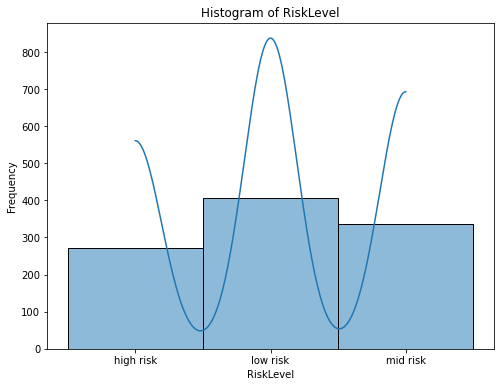

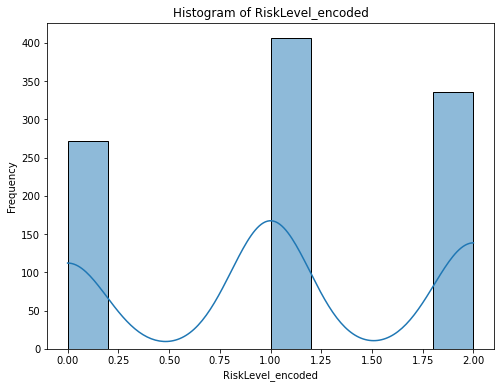

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the function to plot histograms
def plot_histograms(df):
    # Set the number of bins
    num_bins = 10
    
    # Loop through each numerical column and plot its histogram
    for column in df.columns:
        plt.figure(figsize=(8, 6))
        sns.histplot(data=df, x=column, bins=num_bins, kde=True)
        plt.xlabel(column)
        plt.ylabel("Frequency")
        plt.title(f"Histogram of {column}")
        plt.show()

# Call the function to plot histograms for the encoded dataset
plot_histograms(encoded_df)

### 4. Data preprocessing and Feature Engineering Steps

# Keras in Action

# SciKit-Learn 

In [89]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

# Load the dataset
data = pd.read_csv("Maternal_Health_Risk_encoded.csv")

# Separate features and target variable
X = data.drop('RiskLevel_encoded', axis=1)
y = data['RiskLevel_encoded']

# Split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build neural network (NN) model 
nnmodel = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)  # output layer, no activation function
])

# Compile NN model
nnmodel.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train NN model
nnmodel.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)

ValueError: could not convert string to float: 'mid risk'

In [59]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [60]:
# Load the dataset
df = pd.read_csv("Maternal_Health_Risk_encoded.csv")

# Drop non-numeric columns and the label column
X = df.drop(columns=['RiskLevel_encoded', 'RiskLevel'])
y = df['RiskLevel_encoded']

In [61]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [62]:
# Standardize the data using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [87]:
# Create the neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.1630 - mae: 0.9174 - val_loss: 1.2238 - val_mae: 0.9693
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1376 - mae: 0.9142 - val_loss: 1.2232 - val_mae: 0.9693
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0400 - mae: 0.8702 - val_loss: 1.2231 - val_mae: 0.9693
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9662 - mae: 0.8341 - val_loss: 1.2230 - val_mae: 0.9693
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0388 - mae: 0.8682 - val_loss: 1.2230 - val_mae: 0.9693
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.0127 - mae: 0.8551 - val_loss: 1.2229 - val_mae: 0.9693
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0462 - mae: 0.8694 - val_loss: 1.2229 - val_mae: 0.9693
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0512 - mae: 0.8760 - val_loss: 1.2229 - val_mae: 0.9693
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.9909

In [88]:
# Evaluate the model
loss, mae = model.evaluate(X_test_scaled, y_test)
print(f'Mean absolute error (MAE) on test data: {mae}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2021 - mae: 0.9362 
Mean absolute error (MAE) on test data: 0.9638751745223999


In [74]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Load the dataset
data = pd.read_csv("Maternal_Health_Risk_encoded.csv")

# Separate the features (X) and the label (y)
X = data.drop('RiskLevel_encoded', axis=1)
y = data['RiskLevel_encoded']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify the categorical columns
categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']

# Preprocessing of categorical features: one-hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_cols)
    ],
    remainder='passthrough'
)

X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

# Standardize the data using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

In [75]:
data = pd.read_csv("Maternal_Health_Risk_encoded.csv")


In [76]:
X = data.drop('RiskLevel_encoded', axis=1)
y = data['RiskLevel_encoded']

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [78]:
categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']


In [79]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_cols)
    ],
    remainder='passthrough'
)

X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)


In [80]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

In [81]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [82]:
history = model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5180 - loss: 0.7393 - val_accuracy: 0.5951 - val_loss: 0.0516
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6719 - loss: -0.0050 - val_accuracy: 0.5828 - val_loss: -0.7045
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6595 - loss: -0.6541 - val_accuracy: 0.5828 - val_loss: -1.6367
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6687 - loss: -1.4565 - val_accuracy: 0.5828 - val_loss: -3.0085
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6648 - loss: -2.7650 - val_accuracy: 0.5828 - val_loss: -5.2513
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6583 - loss: -4.8711 - val_accuracy: 0.5828 - val_loss: -8.8228
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6854 - loss: -7.5411 - val_accuracy: 0.5828 - val_loss: -14.4148
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6425 - loss: -13.7938 - val_accura

In [83]:
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6336 - loss: -491.8161 
Test Loss: -539.5257568359375, Test Accuracy: 0.6206896305084229
